# 노드학습

### 필요한 라이브러리 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]
    
# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'Main_Quest','CV')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)
print(TRAIN_PATH)

/aiffel/aiffel/Main_Quest/CV
/aiffel/aiffel/Main_Quest/CV/chest_xray/data/train/*/*


### 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train data 89%, validation data 0.3%, test data 10.7%로 validation data의 갯수가 너무 부족함 -> train + val 한 다음, 8:2로 분할해주기

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


##### train data의 normal / pneumonia set 분류하기

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


유병 x-ray 사진이 정상 x-ray 사진보다 3배정도 많다. 추후에 클래스 불균형 조정할 예정!

##### mini-batch 설정하기

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

train/validation set의 갯수도 확인하기

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


라벨데이터 만들어주는 함수 생성

In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

##### 이미지 data type을 float으로 바꾸고, 사이즈를 변경하고, 라벨값을 가져오는 함수 생성하기

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train, validation data set에 위에서 만든 함수 적용시켜 데이터셋 만들기   
AUTOTUNE 변수를 사용 시 빠르게 데이터 처리 가능하다

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

잘 조정되었는지 확인하기, take(1)은 하나의 데이터만 가져온다는 뜻!

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


test data set 만들기

In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 데이터 변환하기

shuffle() : 고정크기 버처를 유지하고, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택   
repeat() : epoch를 진행하면서 여러번 데이터 셋을 불러올 수 있게 해줌   
batch() : batch_size에서 정한만큼 배치 나누어줌   
prefetch() : 학습데이터를 나누어 읽어와 리소스의 유휴상태를 줄일 수 있음(첫번쨰 데이터를 GPU에서 학습하는 동안, 두번째 데이터를 CPU에서 준비할 수 있도록 함)

In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

train data의 첫번째 배치를 추출해서 image, label 데이터셋으로 나누고 show_batch()함수를 이용해 결과사진 출력

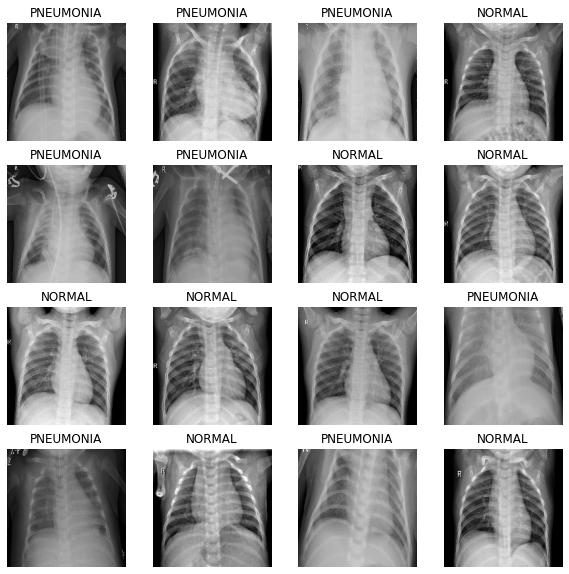

In [86]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링하기

convolution block 생성함수   
(3*3 filter&relu를 사용하는 SeparableConv2D layer 2개 + BatchNormalization + MaxPooling)


In [14]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense block 생성함수

In [15]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

모델 생성

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

##### data imbalance 처리  : weight balancing    
클래스의 건수와 weight이 반비례하도록 설정해줌.   
kears에서는 class_weight에서 가중치를 세팅할 수 있음

In [17]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


Normal : 1/1070 * 4185/2 = 1.955  == 1.96   
Peumonia : 1/3115 * 4185/2 = 0.671   
pneumonia의 데이터 갯수가 더 많아서 학습이 편중될 수 있는 문제를 해결해줌

# 모델훈련 (with GPU)

In [59]:
BATCH_SIZE = 16
EPOCHS = 10

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
        
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "model_origin.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
    ]

In [60]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/10
523/523 [==============================] - 102s 178ms/step - loss: 0.3091 - accuracy: 0.8613 - precision: 0.9633 - recall: 0.8443 - val_loss: 1.3459 - val_accuracy: 0.7558 - val_precision: 0.7558 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 1.34587, saving model to model_origin.h5
Epoch 2/10
523/523 [==============================] - 92s 177ms/step - loss: 0.1887 - accuracy: 0.9299 - precision: 0.9760 - recall: 0.9278 - val_loss: 0.4012 - val_accuracy: 0.8721 - val_precision: 0.9985 - val_recall: 0.8325

Epoch 00002: val_loss improved from 1.34587 to 0.40117, saving model to model_origin.h5
Epoch 3/10
523/523 [==============================] - 92s 176ms/step - loss: 0.1439 - accuracy: 0.9440 - precision: 0.9826 - recall: 0.9408 - val_loss: 0.1484 - val_accuracy: 0.9457 - val_precision: 0.9946 - val_recall: 0.9333

Epoch 00003: val_loss improved from 0.40117 to 0.14838, saving model to model_origin.h5
Epoch 4/10
523/523 [==============================] - 9

epoch 마다 precision, recall, accuracy, loss의 변화 시각화하기

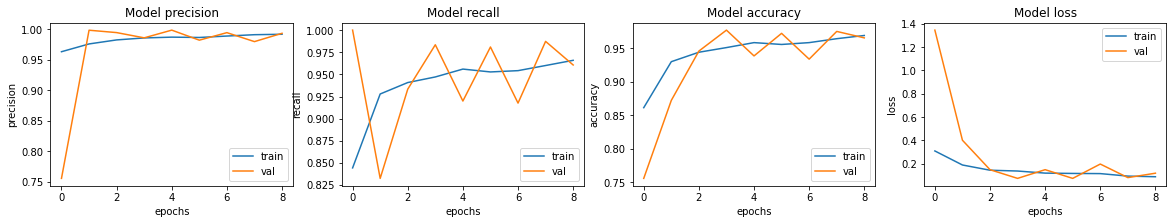

In [61]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

##### 테스트 데이터로 모델 평가하기

In [63]:
model = build_model()
model.load_weights(checkpoint_path)

model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 99ms/step - loss: 0.7766 - accuracy: 0.8141 - precision: 0.9401 - recall: 0.9659
Loss: 0.7766081690788269,
Accuracy: 0.8141025900840759,
Precision: 0.940069317817688,
Recall: 0.9659032821655273


# 성능개선

## 1. batch size, epoch등 변경해보기

### batch size 변경

##### batch size 16 -> 32

In [60]:
BATCH_SIZE = 32
EPOCHS = 10

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
        
with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "model_batch32.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
    ]

In [62]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/10
130/130 [==============================] - 40s 239ms/step - loss: 0.5056 - accuracy: 0.7226 - precision: 0.9425 - recall: 0.6677 - val_loss: 0.6628 - val_accuracy: 0.7148 - val_precision: 0.7148 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 0.66278, saving model to model_batch32.h5
Epoch 2/10
130/130 [==============================] - 29s 225ms/step - loss: 0.2794 - accuracy: 0.8663 - precision: 0.9746 - recall: 0.8426 - val_loss: 0.7097 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000

Epoch 00002: val_loss did not improve from 0.66278
Epoch 3/10
130/130 [==============================] - 30s 229ms/step - loss: 0.2287 - accuracy: 0.9115 - precision: 0.9784 - recall: 0.9017 - val_loss: 0.8687 - val_accuracy: 0.7051 - val_precision: 0.7051 - val_recall: 1.0000

Epoch 00003: val_loss did not improve from 0.66278
Epoch 4/10
130/130 [==============================] - 30s 230ms/step - loss: 0.2159 - accuracy: 0.9236 - precision: 0.9798 - reca

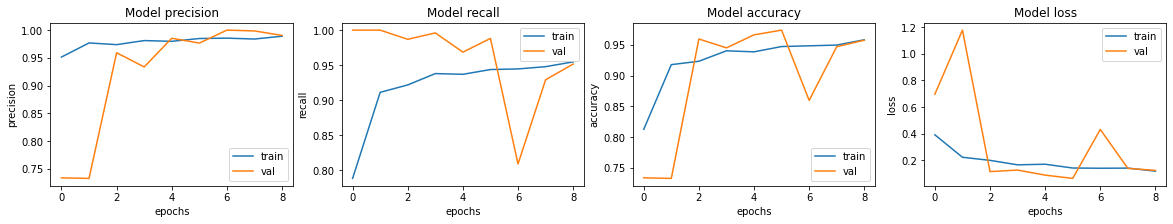

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [64]:
model2 = build_model()
model2.load_weights(checkpoint_path)

model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 108ms/step - loss: 0.6767 - accuracy: 0.6250 - precision: 0.6637 - recall: 1.0000
Loss: 0.6767411231994629,
Accuracy: 0.625,
Precision: 0.6637324094772339,
Recall: 1.0


##### batch size 16 -> 8

In [65]:
BATCH_SIZE = 8
EPOCHS = 10

In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
        
with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "model_batch8.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
    ]

with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/10
523/523 [==============================] - 105s 184ms/step - loss: 0.3129 - accuracy: 0.8571 - precision: 0.9615 - recall: 0.8417 - val_loss: 1.4907 - val_accuracy: 0.7341 - val_precision: 0.7341 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 1.49069, saving model to model_batch8.h5
Epoch 2/10
523/523 [==============================] - 95s 181ms/step - loss: 0.2002 - accuracy: 0.9244 - precision: 0.9767 - recall: 0.9204 - val_loss: 0.2762 - val_accuracy: 0.8788 - val_precision: 0.8583 - val_recall: 1.0000

Epoch 00002: val_loss improved from 1.49069 to 0.27624, saving model to model_batch8.h5
Epoch 3/10
523/523 [==============================] - 96s 184ms/step - loss: 0.1673 - accuracy: 0.9358 - precision: 0.9806 - recall: 0.9323 - val_loss: 0.0974 - val_accuracy: 0.9668 - val_precision: 0.9614 - val_recall: 0.9948

Epoch 00003: val_loss improved from 0.27624 to 0.09737, saving model to model_batch8.h5
Epoch 4/10
523/523 [==============================] - 9

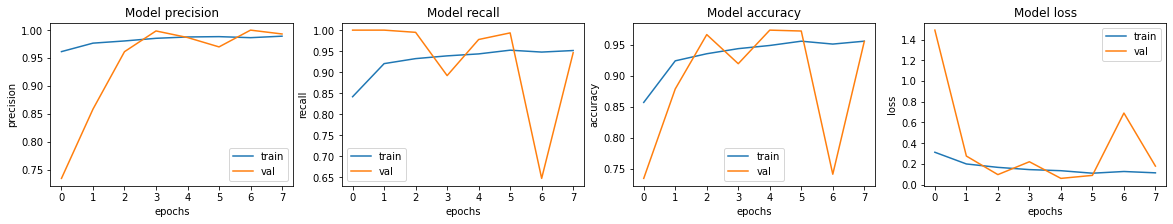

In [67]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [68]:
model3 = build_model()
model3.load_weights(checkpoint_path)

model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 110ms/step - loss: 0.6985 - accuracy: 0.7869 - precision: 0.9293 - recall: 0.9551
Loss: 0.6984643340110779,
Accuracy: 0.7868589758872986,
Precision: 0.9293339848518372,
Recall: 0.9550679326057434


In [69]:
BATCH_SIZE = 32
EPOCHS = 20

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
        
with tf.device('/GPU:0'):
    model4 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "model_batch32_epoch20.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
    ]

with tf.device('/GPU:0'):
    history4 = model4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/20
130/130 [==============================] - 39s 233ms/step - loss: 0.4725 - accuracy: 0.7476 - precision: 0.9365 - recall: 0.7077 - val_loss: 0.5943 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 0.59432, saving model to model_batch32_epoch20.h5
Epoch 2/20
130/130 [==============================] - 29s 224ms/step - loss: 0.2569 - accuracy: 0.8952 - precision: 0.9792 - recall: 0.8782 - val_loss: 0.7013 - val_accuracy: 0.7148 - val_precision: 0.7148 - val_recall: 1.0000

Epoch 00002: val_loss did not improve from 0.59432
Epoch 3/20
130/130 [==============================] - 30s 230ms/step - loss: 0.1990 - accuracy: 0.9269 - precision: 0.9764 - recall: 0.9251 - val_loss: 0.7658 - val_accuracy: 0.7598 - val_precision: 0.7598 - val_recall: 1.0000

Epoch 00003: val_loss did not improve from 0.59432
Epoch 4/20
130/130 [==============================] - 29s 222ms/step - loss: 0.2004 - accuracy: 0.9293 - precision: 0.977

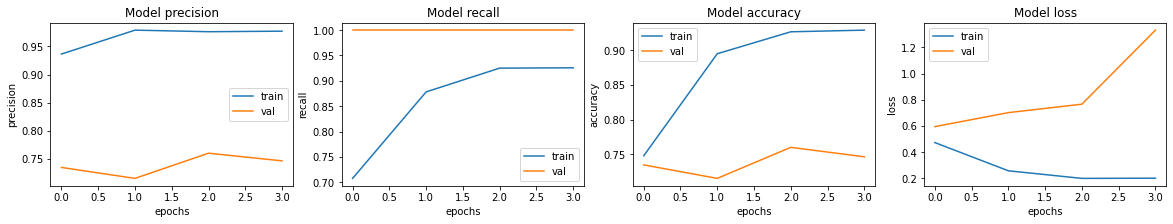

In [70]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [72]:
model4 = build_model()
model4.load_weights(checkpoint_path)

model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 115ms/step - loss: 0.6632 - accuracy: 0.6250 - precision: 0.6602 - recall: 1.0000
Loss: 0.6632035374641418,
Accuracy: 0.625,
Precision: 0.6602272987365723,
Recall: 1.0


### 비교하기

batch size  8, epoch 10 : loss: 0.6985 - accuracy: 0.7869 - precision: 0.9293 - recall: 0.9551  
batch size 16, epoch 10 : loss: 0.7766 - accuracy: 0.8141 - precision: 0.9401 - recall: 0.9659
batch size 32, epoch 10 : loss: 0.6767 - accuracy: 0.6250 - precision: 0.6637 - recall: 1.0000    
batch size 32, epoch 20 : loss: 0.6632 - accuracy: 0.6250 - precision: 0.6796 - recall: 1.0000

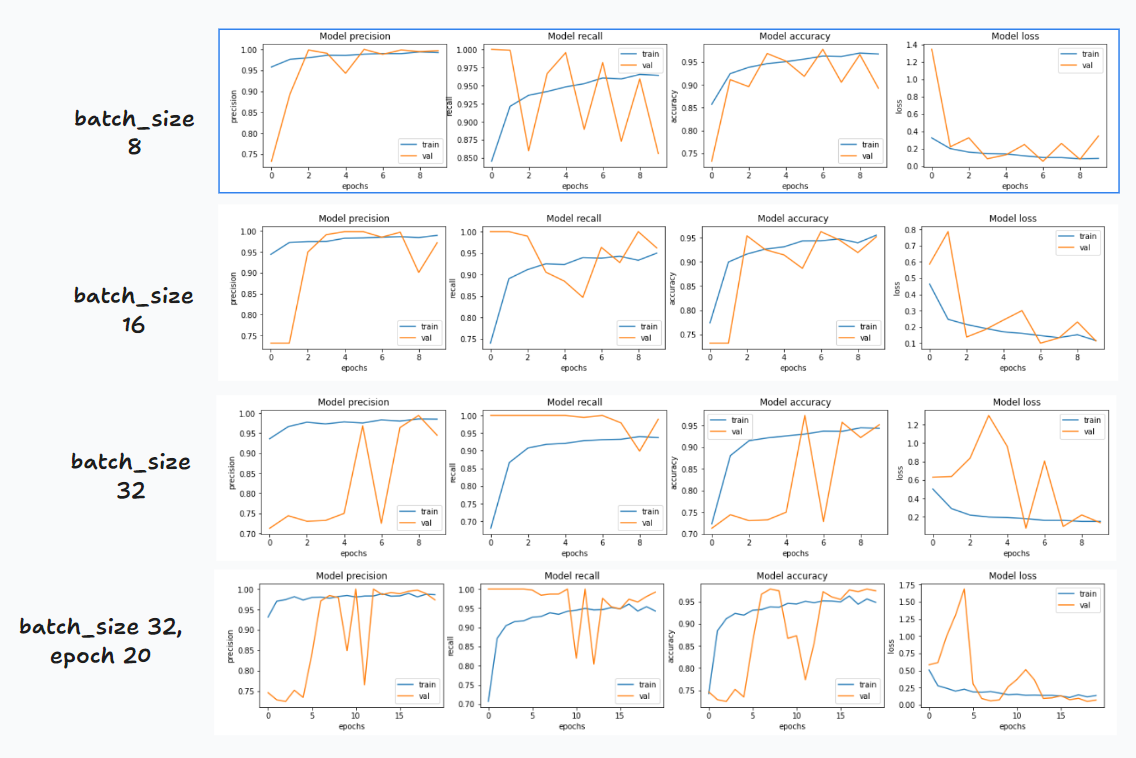

## 2. data augmentation

모든 augmentation 들이 항상 도움이 된다고 말할 수는 없음. 미묘한 노이즈가 방해가 될 가능성이 높기 때문.   
그래서 좌우반전만 시행해볼 예정

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal')
])

def augment(img, label):
    img = data_augmentation(img)
    return img, label

In [19]:
train_ds_aug = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
val_ds_aug = val_ds.map(augment, num_parallel_calls=AUTOTUNE)

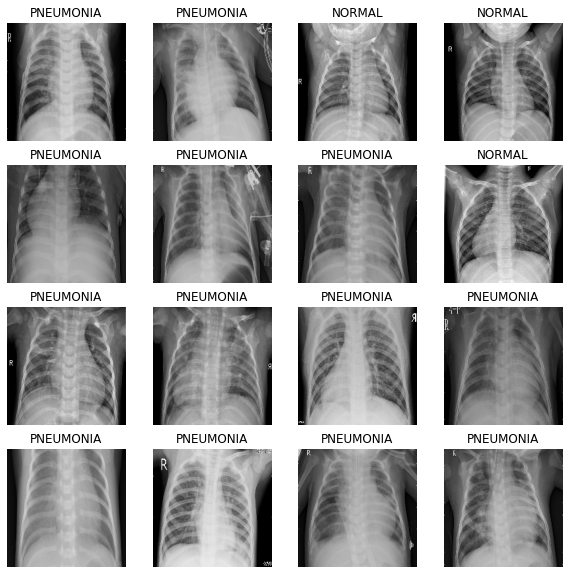

In [17]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds_aug))
show_batch(image_batch.numpy(), label_batch.numpy())

랜덤으로 좌우가 잘 뒤집어진 모습임

### 2-1 data augmentation with batch size 16

In [24]:
BATCH_SIZE = 16
EPOCHS = 10

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
        
with tf.device('/GPU:0'):
    model5 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model5.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "model_aug.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
    ]

In [25]:
with tf.device('/GPU:0'):
    history5 = model5.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/10
261/261 [==============================] - 110s 202ms/step - loss: 0.3570 - accuracy: 0.8269 - precision: 0.9567 - recall: 0.8018 - val_loss: 0.7046 - val_accuracy: 0.7558 - val_precision: 0.7558 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 0.70463, saving model to model_aug.h5
Epoch 2/10
261/261 [==============================] - 51s 197ms/step - loss: 0.2302 - accuracy: 0.9186 - precision: 0.9764 - recall: 0.9118 - val_loss: 1.0963 - val_accuracy: 0.7548 - val_precision: 0.7548 - val_recall: 1.0000

Epoch 00002: val_loss did not improve from 0.70463
Epoch 3/10
261/261 [==============================] - 52s 199ms/step - loss: 0.2100 - accuracy: 0.9265 - precision: 0.9731 - recall: 0.9261 - val_loss: 0.1178 - val_accuracy: 0.9587 - val_precision: 0.9857 - val_recall: 0.9594

Epoch 00003: val_loss improved from 0.70463 to 0.11777, saving model to model_aug.h5
Epoch 4/10
261/261 [==============================] - 52s 199ms/step - loss: 0.1936 - accuracy: 0.

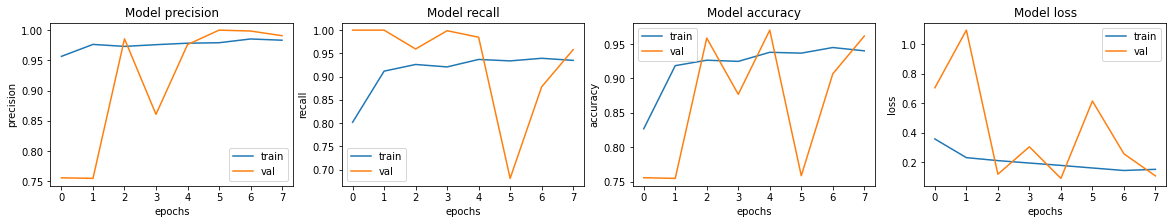

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history5.history[met])
    ax[i].plot(history5.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
model5 = build_model()
model5.load_weights(checkpoint_path)

model5.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall = model5.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 122ms/step - loss: 0.7396 - accuracy: 0.7516 - precision: 0.8770 - recall: 0.9702
Loss: 0.7395925521850586,
Accuracy: 0.7516025900840759,
Precision: 0.8770176768302917,
Recall: 0.9702380895614624


### 2-2 data augmentation with batch size 8

In [28]:
BATCH_SIZE = 8
EPOCHS = 10

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
        
with tf.device('/GPU:0'):
    model6 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model6.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "model_aug_bs8.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
    ]

In [29]:
with tf.device('/GPU:0'):
    history6 = model6.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/10
523/523 [==============================] - 104s 181ms/step - loss: 0.2995 - accuracy: 0.8660 - precision: 0.9664 - recall: 0.8481 - val_loss: 1.1287 - val_accuracy: 0.7567 - val_precision: 0.7567 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 1.12868, saving model to model_aug_bs8.h5
Epoch 2/10
523/523 [==============================] - 95s 181ms/step - loss: 0.1974 - accuracy: 0.9227 - precision: 0.9736 - recall: 0.9203 - val_loss: 0.0834 - val_accuracy: 0.9673 - val_precision: 0.9700 - val_recall: 0.9873

Epoch 00002: val_loss improved from 1.12868 to 0.08344, saving model to model_aug_bs8.h5
Epoch 3/10
523/523 [==============================] - 93s 179ms/step - loss: 0.1718 - accuracy: 0.9381 - precision: 0.9784 - recall: 0.9369 - val_loss: 0.0804 - val_accuracy: 0.9697 - val_precision: 0.9689 - val_recall: 0.9917

Epoch 00003: val_loss improved from 0.08344 to 0.08044, saving model to model_aug_bs8.h5
Epoch 4/10
523/523 [==============================] 

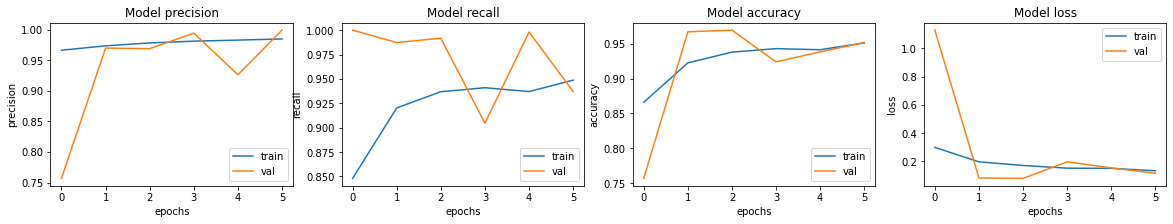

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history6.history[met])
    ax[i].plot(history6.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
model6 = build_model()
model6.load_weights(checkpoint_path)

model6.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall = model6.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 101ms/step - loss: 0.9463 - accuracy: 0.7212 - precision: 0.9146 - recall: 0.9491
Loss: 0.9463238716125488,
Accuracy: 0.7211538553237915,
Precision: 0.9146221876144409,
Recall: 0.9490835070610046


### 2-3 data augmentation with batch size 32

In [64]:
BATCH_SIZE = 32
EPOCHS = 10

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
        
with tf.device('/GPU:0'):
    model8 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model8.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "model_aug_bs32.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
    ]

In [65]:
with tf.device('/GPU:0'):
    history8 = model8.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/10
130/130 [==============================] - 38s 228ms/step - loss: 0.5335 - accuracy: 0.7106 - precision: 0.9186 - recall: 0.6647 - val_loss: 0.6050 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 0.60503, saving model to model_aug_bs32.h5
Epoch 2/10
130/130 [==============================] - 29s 223ms/step - loss: 0.3368 - accuracy: 0.8433 - precision: 0.9594 - recall: 0.8243 - val_loss: 0.5788 - val_accuracy: 0.7656 - val_precision: 0.7656 - val_recall: 1.0000

Epoch 00002: val_loss improved from 0.60503 to 0.57878, saving model to model_aug_bs32.h5
Epoch 3/10
130/130 [==============================] - 29s 225ms/step - loss: 0.2610 - accuracy: 0.8861 - precision: 0.9705 - recall: 0.8732 - val_loss: 0.7521 - val_accuracy: 0.7480 - val_precision: 0.7480 - val_recall: 1.0000

Epoch 00003: val_loss did not improve from 0.57878
Epoch 4/10
130/130 [==============================] - 29s 228ms/step - loss: 0.2209 - acc

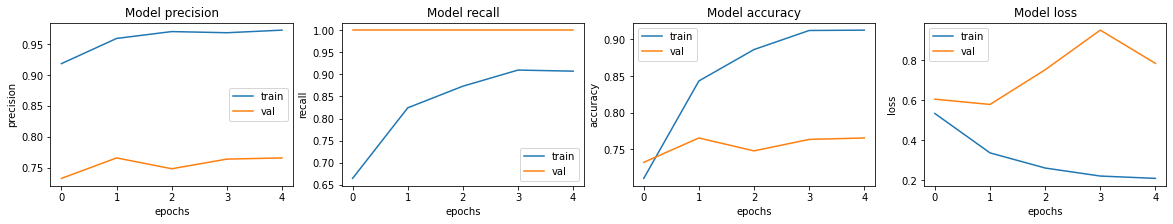

In [66]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history8.history[met])
    ax[i].plot(history8.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [67]:
model8_1 = build_model()
model8_1.load_weights(checkpoint_path)

model8_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall = model8_1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 107ms/step - loss: 0.8378 - accuracy: 0.6250 - precision: 0.6884 - recall: 1.0000
Loss: 0.8377802968025208,
Accuracy: 0.625,
Precision: 0.6883803009986877,
Recall: 1.0


data augmentation   
batch size 8  : loss: 0.7396 - accuracy: 0.7516 - precision: 0.8770 - recall: 0.9702   
batch size 16 : loss: 0.9463 - accuracy: 0.7212 - precision: 0.9146 - recall: 0.9491   
batch size 32 : loss: 0.8378 - accuracy: 0.6250 - precision: 0.6884 - recall: 1.0000   
(batch size 8에서 훨씬 좋은 성능을 보임(loss 값 기준)
----------
batch size  8, epoch 10 : loss: 0.6985 - accuracy: 0.7869 - precision: 0.9293 - recall: 0.9551  
batch size 16, epoch 10 : loss: 0.7766 - accuracy: 0.8141 - precision: 0.9401 - recall: 0.9659  
batch size 32, epoch 10 : loss: 0.6767 - accuracy: 0.6250 - precision: 0.6637 - recall: 1.0000    
batch size 32, epoch 20 : loss: 0.6632 - accuracy: 0.6250 - precision: 0.6796 - recall: 1.0000   
(어짜피 epoch 10 미만에서 earlystop되어 epoch 늘리는 것이 의미가 없었음)   

--->   
의료데이터이기 때문에, Recall이 사실 제일 중요하다..?
early stop을 val_loss 값을 기준으로 학습시켰기 때문에, recall 값에 대한 신빙성이 떨어진다... 
다시 recall값을 기준으로 다 갈아엎고 처음부터 재학습필요!!

# ※ 3. F1-score을 기준으로 재학습 시키기 ※

###### metrics 설명:         
Precision(정밀도) : 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율   
Recall(재현율) : 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율   
F1_score = 2 * (precision * recall) / (precision + recall) 으로 모델의 전반적인 성능을 평가하는데 유용함

##### Recall vs F1-Score   
###### Recall   
장점: Recall은 실제 양성 클래스(폐렴)를 정확하게 예측하는 능력을 측정합니다.   
      특히, 폐렴 같은 중요한 의료 진단에서는 양성 샘플을 놓치지 않는 것이 중요할 수 있습니다.   
단점: Precision을 고려하지 않기 때문에, 모든 샘플을 양성으로 예측하면 높은 값을 가질 수 있습니다.   
###### F1-Score
장점: F1-Score는 Precision과 Recall의 조화 평균입니다.   
      이는 모델의 전반적인 균형 잡힌 성능을 평가합니다
      F1-Score가 최대값에 도달했다는 것은 모델이 양성 샘플을 정확하게 예측하고,    
      동시에 대부분의 양성 샘플을 놓치지 않고 잘 예측하고 있다는 것을 의미합니다.    
      이는 모델의 전반적인 성능이 최적임을 나타냅니다.
단점: Recall에 비해 해석이 약간 복잡할 수 있습니다.   
###### Chat-CPT의 추천
폐렴 진단 모델에서는 환자를 놓치는 것이 큰 문제가 될 수 있으므로,   
Recall을 주요 지표로 사용하는 것이 일반적입니다.   
그러나, 모델의 전반적인 균형 성능을 고려하여 F1-Score를 사용하는 것도 유효합니다.

###### -> 
recall값을 기준으로 earlystopping과 modelcheckpoint를 먼저 적용해 보려고 했으나, 
학습 1,2 epoch때 recall값이 이미 1을 찍고, 학습이 진행될수록 값이 떨어지는게 확인됨.   
또, 서서히 떨어지다가 최저점을 찍고 다시 올라가는데,    
어디를 기준으로 model의 최적치를 정해야할 지 모르겠다.   
그리고 prediction 값은 0에서 시작해서 올라가므로 F1_score을 쓰는것이 합당할 것으로 보인다.

F1_score 모듈은 Tensorflow Addons에 포함된 것으로 패키지 설치함

In [71]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


### 3-1 batch_size = 16

어짜피 early stopping 적용할거라 epoch는 20으로 세팅

In [48]:
BATCH_SIZE = 16
EPOCHS = 20

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa
        
with tf.device('/GPU:0'):
    model10 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(name='f1_score', num_classes=1)
    ]
    
    model10.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "model_r_bs16.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_f1_score', patience=10, mode='max', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_f1_score', save_best_only=True, mode='max', verbose =1)
    ]

In [49]:
with tf.device('/GPU:0'):
    history10 = model10.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/20
261/261 [==============================] - 62s 202ms/step - loss: 0.3494 - accuracy: 0.8434 - precision: 0.9630 - recall: 0.8211 - f1_score: 0.8534 - val_loss: 0.6513 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000 - val_f1_score: 0.8464

Epoch 00001: val_f1_score improved from -inf to 0.84637, saving model to model_r_bs16.h5
Epoch 2/20
261/261 [==============================] - 51s 194ms/step - loss: 0.2428 - accuracy: 0.9037 - precision: 0.9698 - recall: 0.8988 - f1_score: 0.8542 - val_loss: 1.2772 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000 - val_f1_score: 0.8457

Epoch 00002: val_f1_score did not improve from 0.84637
Epoch 3/20
261/261 [==============================] - 51s 196ms/step - loss: 0.2138 - accuracy: 0.9164 - precision: 0.9706 - recall: 0.9153 - f1_score: 0.8531 - val_loss: 0.2427 - val_accuracy: 0.8779 - val_precision: 0.8571 - val_recall: 1.0000 - val_f1_score: 0.8457

Epoch 00003: val_f1_score did not improve from

epoch 5의 모델이 저장됨,  전반적으로 val_loss값,val_accuracy기준 최적적합 지점으로 보이며,   
val_precision, val_recall 값도 처음을 제외하고는 최대지점으로 확인됨

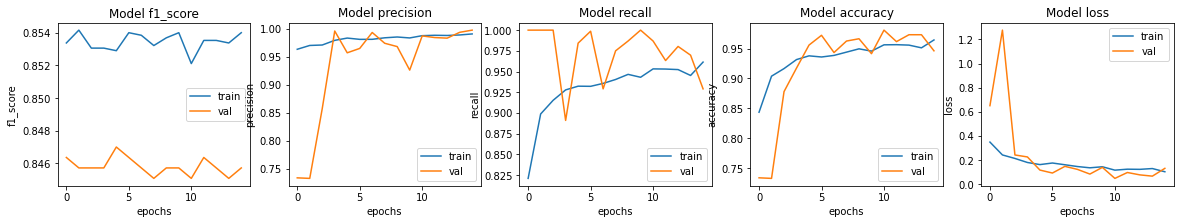

In [50]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['f1_score', 'precision', 'recall','accuracy', 'loss']):
    ax[i].plot(history10.history[met])
    ax[i].plot(history10.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
model10_1 = build_model()
model10_1.load_weights(checkpoint_path)

model10_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall, f1_score = model10_1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}, \nF1_Score:{f1_score}')

39/39 [==============================] - 5s 120ms/step - loss: 0.7565 - accuracy: 0.7516 - precision: 0.8767 - recall: 0.9505 - f1_score: 0.8182
Loss: 0.7565014362335205,
Accuracy: 0.7516025900840759,
Precision: 0.8767013549804688,
Recall: 0.9505208134651184, 
F1_Score:[0.8181818]


### 3-2 batch size 8

In [35]:
BATCH_SIZE = 8
EPOCHS = 20

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa
        
with tf.device('/GPU:0'):
    model11 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(name='f1_score', num_classes=1)
    ]
    
    model11.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "model_r_bs8.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_f1_score', patience=10, mode='max', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_f1_score', save_best_only=True, mode='max', verbose =1)
    ]

with tf.device('/GPU:0'):
    history11 = model11.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/20
523/523 [==============================] - 105s 183ms/step - loss: 0.2981 - accuracy: 0.8627 - precision: 0.9627 - recall: 0.8484 - f1_score: 0.8534 - val_loss: 1.2548 - val_accuracy: 0.7332 - val_precision: 0.7332 - val_recall: 1.0000 - val_f1_score: 0.8460

Epoch 00001: val_f1_score improved from -inf to 0.84605, saving model to model_r_bs8.h5
Epoch 2/20
523/523 [==============================] - 95s 182ms/step - loss: 0.1901 - accuracy: 0.9261 - precision: 0.9749 - recall: 0.9245 - f1_score: 0.8535 - val_loss: 0.2115 - val_accuracy: 0.9312 - val_precision: 0.9880 - val_recall: 0.9174 - val_f1_score: 0.8460

Epoch 00002: val_f1_score did not improve from 0.84605
Epoch 3/20
523/523 [==============================] - 96s 183ms/step - loss: 0.1750 - accuracy: 0.9369 - precision: 0.9792 - recall: 0.9351 - f1_score: 0.8535 - val_loss: 0.2305 - val_accuracy: 0.9053 - val_precision: 0.9963 - val_recall: 0.8743 - val_f1_score: 0.8470

Epoch 00003: val_f1_score improved from 0.8460

epoch3의 모델이 저장되었다.

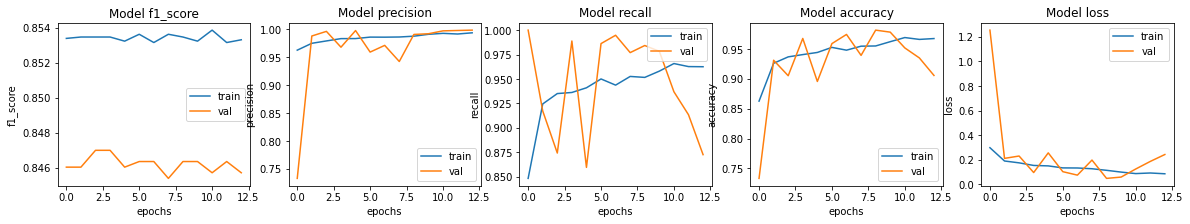

In [45]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['f1_score', 'precision', 'recall','accuracy', 'loss']):
    ax[i].plot(history11.history[met])
    ax[i].plot(history11.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [38]:
model11_1 = build_model()
model11_1.load_weights(checkpoint_path)

model11_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall, f1_score = model11_1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}, \nF1_Score:{f1_score}')

39/39 [==============================] - 5s 109ms/step - loss: 0.3749 - accuracy: 0.8478 - precision: 0.9587 - recall: 0.8861 - f1_score: 0.8289
Loss: 0.3749195635318756,
Accuracy: 0.8477563858032227,
Precision: 0.9587337374687195,
Recall: 0.8861023783683777, 
F1_Score:[0.8289303]


### 3-3 batch size 32

In [39]:
BATCH_SIZE = 32
EPOCHS = 20

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa
        
with tf.device('/GPU:0'):
    model12 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(name='f1_score', num_classes=1)
    ]
    
    model12.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "model_r_bs32.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_f1_score', patience=10, mode='max', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_f1_score', save_best_only=True, mode='max', verbose =1)
    ]

In [41]:
with tf.device('/GPU:0'):
    history12 = model12.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/20
130/130 [==============================] - 39s 233ms/step - loss: 0.5644 - accuracy: 0.7091 - precision: 0.9214 - recall: 0.6632 - f1_score: 0.8502 - val_loss: 0.7230 - val_accuracy: 0.2598 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.8507

Epoch 00001: val_f1_score improved from -inf to 0.85073, saving model to model_r_bs32.h5
Epoch 2/20
130/130 [==============================] - 29s 224ms/step - loss: 0.3170 - accuracy: 0.8519 - precision: 0.9658 - recall: 0.8321 - f1_score: 0.8571 - val_loss: 0.6946 - val_accuracy: 0.7070 - val_precision: 0.7070 - val_recall: 1.0000 - val_f1_score: 0.8284

Epoch 00002: val_f1_score did not improve from 0.85073
Epoch 3/20
130/130 [==============================] - 30s 232ms/step - loss: 0.2836 - accuracy: 0.8856 - precision: 0.9657 - recall: 0.8794 - f1_score: 0.8593 - val_loss: 1.2482 - val_accuracy: 0.6953 - val_precision: 0.6953 - val_recall: 1.0000 - val_f1_score: 0.8203

Epoch 00003: val_f1_score did not impr

epoch 8 모델이 저장됨, epoch 9에서 val_recall, val_accuracy, val_loss값이 급변하는 모습

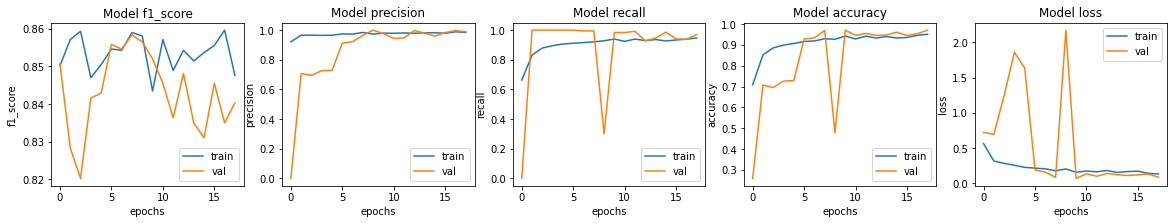

In [52]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['f1_score', 'precision', 'recall','accuracy', 'loss']):
    ax[i].plot(history12.history[met])
    ax[i].plot(history12.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [43]:
model12_1 = build_model()
model12_1.load_weights(checkpoint_path)

model12_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall, f1_score = model12_1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}, \nF1_Score:{f1_score}')

39/39 [==============================] - 5s 111ms/step - loss: 0.7467 - accuracy: 0.7372 - precision: 0.8184 - recall: 0.9829 - f1_score: 0.8023
Loss: 0.7466949820518494,
Accuracy: 0.7371794581413269,
Precision: 0.8183807730674744,
Recall: 0.9829171895980835, 
F1_Score:[0.8023194]


### 비교하기

F1-score을 기준으로 callback 적용   
batch  8 : loss: 0.3749 - accuracy: 0.8478 - precision: 0.9587 - recall: 0.8861 - f1_score: 0.8289 (epoch3의 모델)   
batch 16 : loss: 0.7565 - accuracy: 0.7516 - precision: 0.8767 - recall: 0.9505 - f1_score: 0.8182 (epoch5의 모델)   
batch 32 : loss: 0.7467 - accuracy: 0.7372 - precision: 0.8184 - recall: 0.9829 - f1_score: 0.8023 (epoch8의 모델)

batch가 작을수록 epoch을 많이 돌지는 못했지만 recall값을 제외한 loss, accuracy, precision,f1_score값은 제일 좋은 것으로 확인된다.   
그러나 batch가 작을수록 epoch이 많이 돌지 못하고 학습이 일찍 종료됐기 때문에,   
어떤 값이 더 좋은 일반화 성능을 낼지는 아직 잘 모르겠다. 

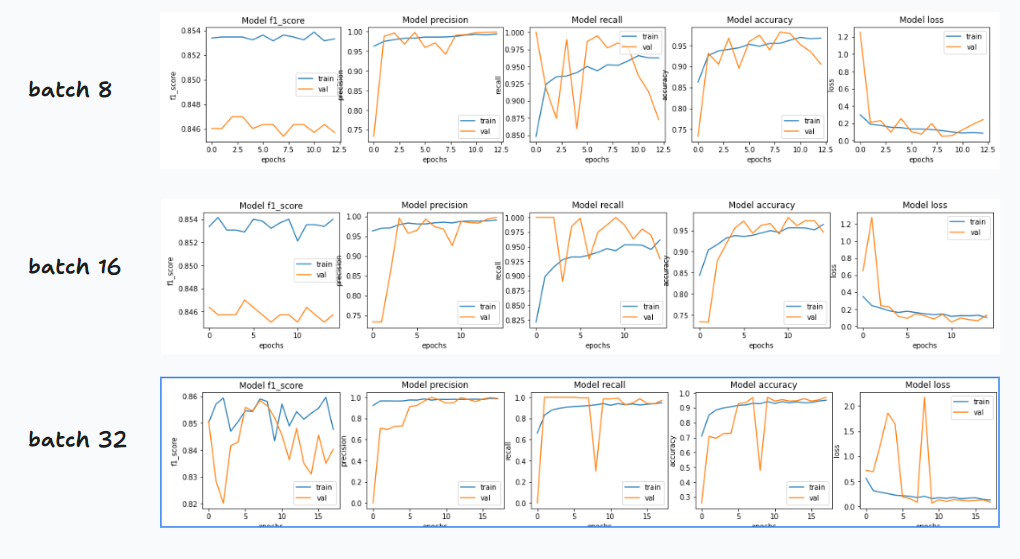

# 4. ResNet-18 구현

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add

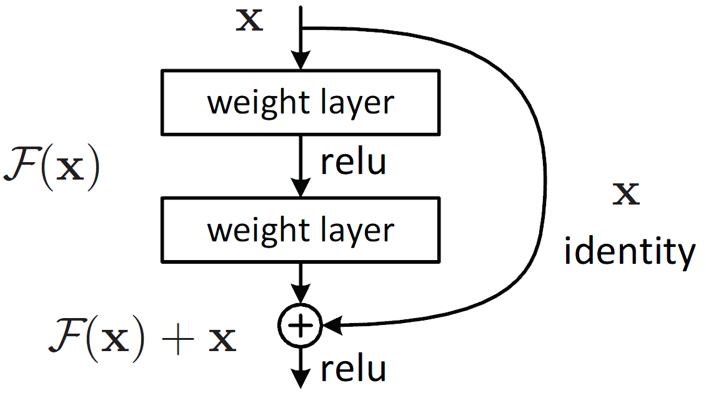

In [21]:
def residual_block(input_tensor, filters):
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # 입력 텐서의 채널 수를 출력 텐서의 채널 수와 일치시키기 위한 1x1 컨볼루션
    if input_tensor.shape[-1] != filters:
        input_tensor = tf.keras.layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)

    x = tf.keras.layers.Add()([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [22]:
def resnet_dense_block(input_tensor, units):
    x = tf.keras.layers.Dense(units, activation='relu')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

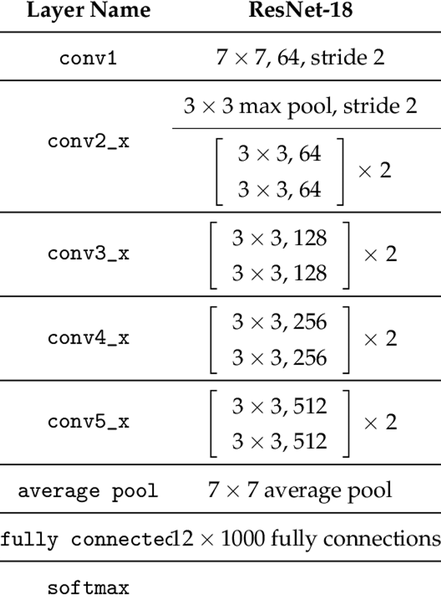

In [38]:
def create_resnet():
    #input
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    #conv1
    x = tf.keras.layers.Conv2D(64, 7, padding='same', strides=2)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    #conv2_x
    x = tf.keras.layers.MaxPool2D(2, strides=2)(x)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    #conv3_x
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    #conv4_x
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    #conv5_x
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    #average_pool
    x = tf.keras.layers.AveragePooling2D(7)(x)
    #FC_layer
    x = tf.keras.layers.Flatten()(x) 
    x = resnet_dense_block(x, 1000)
    x = resnet_dense_block(x, 1000)
    #output
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

### batch 16

In [39]:
BATCH_SIZE = 16
EPOCHS = 20

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa
        
with tf.device('/GPU:0'):
    model20 = create_resnet()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(name='f1_score', num_classes=1)
    ]
    
    model20.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "resnet_16.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_f1_score', patience=10, mode='max', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_f1_score', save_best_only=True, mode='max', verbose =1)
    ]

In [40]:
with tf.device('/GPU:0'):
    history20 = model20.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/20
261/261 [==============================] - 102s 342ms/step - loss: 0.3140 - accuracy: 0.8693 - precision: 0.9592 - recall: 0.8611 - f1_score: 0.8537 - val_loss: 2.8705 - val_accuracy: 0.6144 - val_precision: 0.9945 - val_recall: 0.4764 - val_f1_score: 0.8491

Epoch 00001: val_f1_score improved from -inf to 0.84913, saving model to resnet_16.h5
Epoch 2/20
261/261 [==============================] - 90s 344ms/step - loss: 0.2589 - accuracy: 0.9066 - precision: 0.9660 - recall: 0.9063 - f1_score: 0.8531 - val_loss: 7.0648 - val_accuracy: 0.3404 - val_precision: 0.9875 - val_recall: 0.1034 - val_f1_score: 0.8497

Epoch 00002: val_f1_score improved from 0.84913 to 0.84967, saving model to resnet_16.h5
Epoch 3/20
261/261 [==============================] - 90s 344ms/step - loss: 0.2020 - accuracy: 0.9260 - precision: 0.9759 - recall: 0.9234 - f1_score: 0.8532 - val_loss: 12.5497 - val_accuracy: 0.3048 - val_precision: 1.0000 - val_recall: 0.0549 - val_f1_score: 0.8176

Epoch 00003: 

epoch 2 모델이 저장됨! 전반적으로 높은 값이지만 학습이 너무 진행되지 않아서 개선이 필요할 것으로 보임

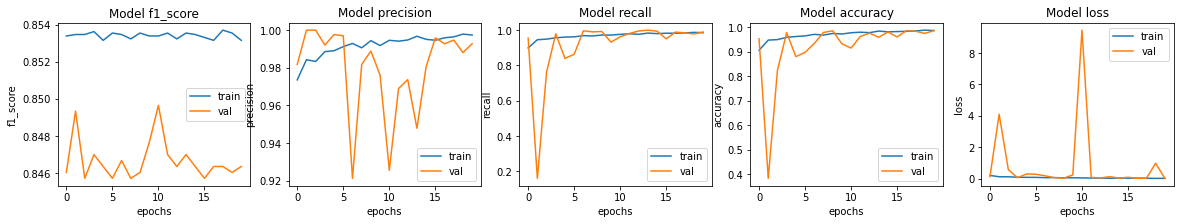

In [28]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['f1_score', 'precision', 'recall','accuracy', 'loss']):
    ax[i].plot(history20.history[met])
    ax[i].plot(history20.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
model20_1 = create_resnet()
model20_1.load_weights(checkpoint_path)

model20_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
loss, accuracy, precision, recall, f1_score = model20_1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}, \nF1_Score:{f1_score}')

39/39 [==============================] - 6s 122ms/step - loss: 52.9039 - accuracy: 0.7388 - precision: 0.8804 - recall: 0.9801 - f1_score: 0.8186
Loss: 52.90394592285156,
Accuracy: 0.7387820482254028,
Precision: 0.8804051280021667,
Recall: 0.9800520539283752, 
F1_Score:[0.81860137]


### 회고

이것저것 하다보니, 노드에서 data imbalance 처리하는것과 optimizer, learning rate의 변화에 대해서는 다루지 못했다.   
이건 개인학습으로 마저 해보는 것으로!
metrics에 대해서 생각을 많이 해보게 된 경험이었고,    
batch size와 일반화, 과대적합간의 비교는 이 학습에서는 알고있던것과 조금 다른점이 있어 공부를 더 해봐야 할 것 같다.   
resnet도 모델을 구상해보니 재밌었고, 예상했던 결과가 나오지 않아서, 이것도 추가 학습이 필요할 것으로 보인다.

# 참고문헌

1. https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D   
2. https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
3. https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu
4. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add
5. https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D 
6. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense   
7. https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score   


8. https://chaeso-coding.tistory.com/153   
9. https://daeun-computer-uneasy.tistory.com/85   
